In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor

import matplotlib
import matplotlib.pyplot as plt

import cv2
import numpy as np
import random, math

from keras import models, layers, optimizers

from collections import deque

import glob, io, base64

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

from google.colab import files

gymlogger.set_level(40) #error only
%matplotlib inline

selected_env = 'Enduro-v0'

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  print("env",env)
  env = Monitor(env, './video', force=True)
  return env

display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

env <TimeLimit<AtariEnv<Enduro-v0>>>
frame_count 4437


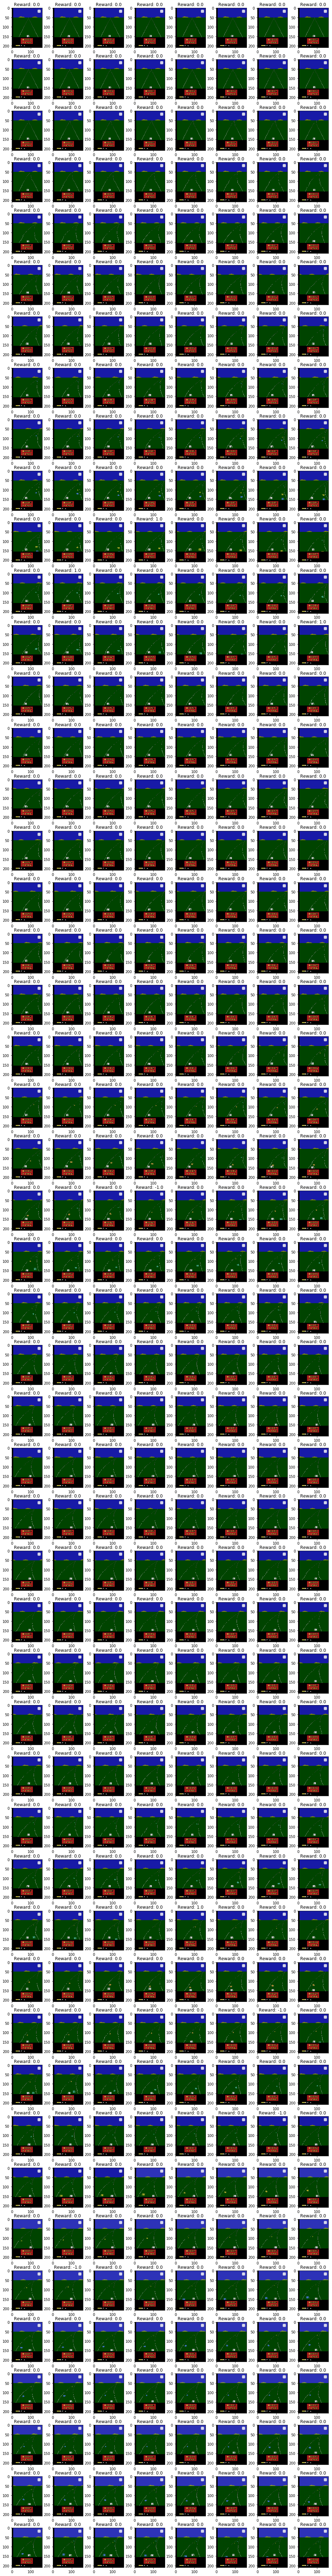

In [0]:
# Loads the cartpole environment
env = wrap_env(gym.make(selected_env))

observation = env.reset()

actual_reward = -900
imgCount = 1
frame_count = 0
done = False
debug = False
while not done:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample()
    action = random.randint(1, 1) 
    #print("action",action)
    observation, reward, done, info = env.step(1) 
    #print(reward)
    #if frame_count % 20 == 0: # Para analizar todo el juego
    if frame_count < 400: # Para analizar el reward
      #print("reward", reward)
      #print(observation.shape)
      actual_reward = reward
      plt.subplot(60,8,imgCount)
      plt.title("Reward: "+str(reward))
      plt.imshow(observation)
      plt.legend('A simple line')
      imgCount+=1
      
    frame_count+=1
    if done: 
      break;
    if debug:
      if(frame_count == 200):
        break;
print("frame_count",frame_count)
plt.subplots_adjust(top=30,right=2.2,hspace=0.3)
env.close()
#show_video()

In [0]:
env = wrap_env(gym.make(selected_env))
print(env.unwrapped.get_action_meanings())
observation = env.reset()
done = False
debug = True
while not done:
    env.render()
    
    #your agent goes here
    #action = env.action_space.sample()
    #action = random.randint(0, 2) 
    #action = 1 if action == 0 else 7 if action == 1 else 8
    action = random.randint(1, 3) 
    #print("action",action)
    observation, reward, done, info = env.step(action)
    #print(reward)
    #print("info",info)
    if done: 
      break;
    if debug:
      if(frame_count == 20):
        break;
env.close()
show_video()

env <TimeLimit<AtariEnv<Enduro-v0>>>
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [0]:
def preprocessFrame(image,multiply=False):
  #print(image.shape)
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = image[(image.shape[0]-210+2):image.shape[0]-55, 7:image.shape[1]]

  #print(image.shape)
  #print("image.mean()",image.mean())
  if(image.mean()>180 and image.mean()<190):
    thresh = 0.9 * image.max()
    strong_corners = np.zeros(image.shape)
    strong_corners[image>thresh]=[255]
    strong_corners = 1 / (255 + strong_corners)
  elif(image.mean()>70 and image.mean()<80):
    thresh = 0.8 * image.max()
    strong_corners = np.zeros(image.shape)
    strong_corners[image>thresh]=[255]
  else:
    thresh = 0.35 * image.max()
    strong_corners = np.zeros(image.shape)
    strong_corners[image>thresh]=[255]
    
  #print("thresh",thresh)
  strong_corners[0:49, 0:strong_corners.shape[1]] = strong_corners.min()

  return strong_corners.astype(np.float).ravel() if multiply else strong_corners
  #return image



env <TimeLimit<AtariEnv<Enduro-v0>>>
imgCount 16
x 4435
(153, 153)


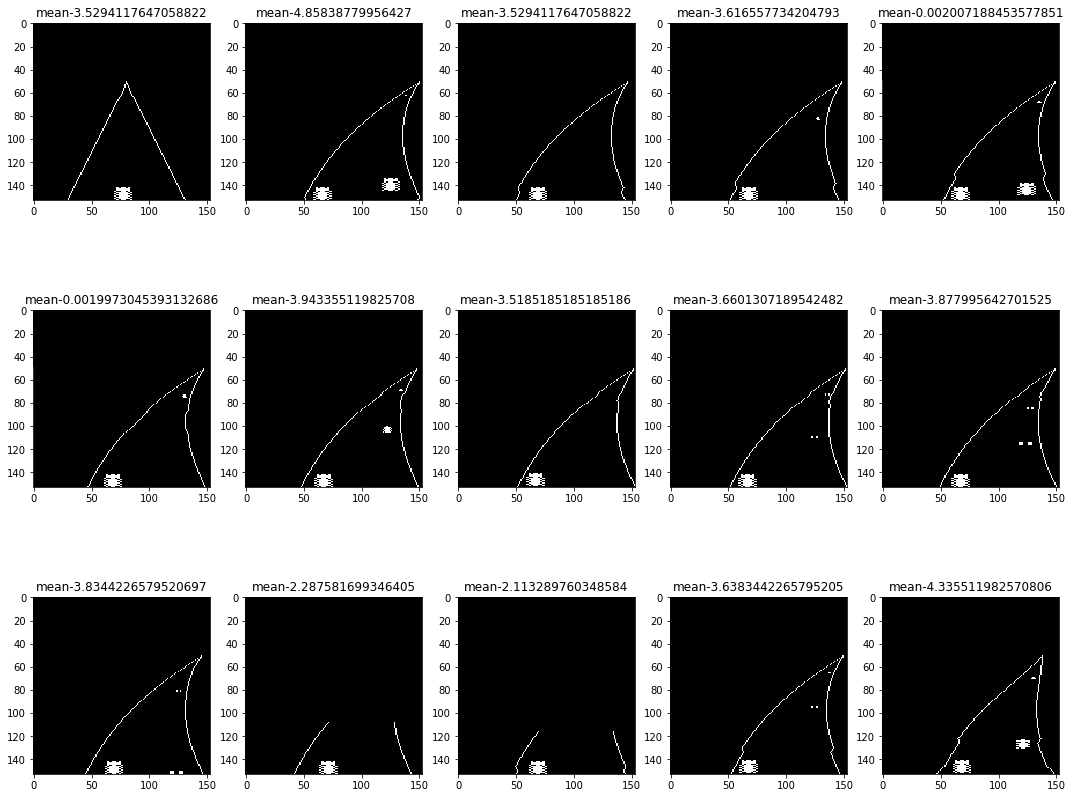

In [0]:
env = wrap_env(gym.make(selected_env))
observation = env.reset()

plt.imshow(preprocessFrame(observation),cmap="gray")
if(True):
  x = 0
  imgCount = 1
  done = False
  while not done: 
      env.render()

      action = env.action_space.sample()
      observation, reward, done, info = env.step(action)
      if x % 300 == 0:
        plt.subplot(10,5,imgCount)
        observation_processed = preprocessFrame(observation)
        plt.title("mean-"+str(observation_processed.mean()))
        plt.imshow(observation_processed, cmap="gray")
        imgCount+=1
      x+=1

      if done: 
        break;
  print("imgCount",imgCount)
  print("x",x)
  print(preprocessFrame(observation).shape)
  plt.subplots_adjust(top=10,right=2.5,hspace=0.1)
  env.close()

In [0]:
# IDEA: Buscar donde se obtuvo un 1 en reward pasar a 2 y asignarle ese 2 a 4 cuádros atrás
# IDEA: Pasar todos los 0's a 1's
# IDEA: Buscar los -1's y asignarle -1 a 9 cuádros atrás
def discount_rewards(reward, gamma):
  r = np.array(reward)
  #print("r",r.shape)
  discounted_r = np.zeros_like(r)
  #print("discounted_r",discounted_r.shape)
  #running_add = 0
    
  #for t in reversed(range(0, r.size)):
    #if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
    #running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
    #discounted_r[t] = running_add
    
  #discounted_r = r
  lastRewardPos = -1
  for t in range(0, r.size):
    if r[t] == 1:
      for ix in range(0,5):
        discounted_r[t-ix] = 2
      lastRewardPos = t
    elif r[t] == 0:
        discounted_r[t] = -1 if t-lastRewardPos > 10 else 0
    elif r[t] == -1:
      for ix in range(0,9):
        discounted_r[t-ix] = -1
  #print("discounted_r",discounted_r.shape)
  #discounted_r -= np.mean(discounted_r) #normalizing the result
  #discounted_r /= np.std(discounted_r) #idem
  return discounted_r

In [0]:
tmp = [0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,-1.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
print("discount_rewards",discount_rewards(tmp,1))

discount_rewards [ 0.  0.  0.  0.  2.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [0]:
class DQNAgent:
    
    def __init__(self, state_dim, action_size):
      
        self.state_dim = state_dim
        self.action_size = action_size
                
        self.gamma = 0.99
        
        self.model = self._build_model()
        

    def _build_model(self):
        
        model = models.Sequential()
        
        model.add(layers.Dense(200,input_dim=self.state_dim, activation='relu', kernel_initializer='glorot_uniform'))

        
        model.add(layers.Dense(self.action_size, activation='relu', kernel_initializer='RandomNormal'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
            
    def train(self, states, labels, rewards):
        #sample_weight: Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only). 
        self.model.fit(x=np.vstack(states), y = np.vstack(labels), verbose = 0, sample_weight = discount_rewards(rewards, self.gamma))
    
    def action(self, state):
        prediction = self.model.predict(state)
        return np.argmax(prediction)
           
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)
        #files.download(name)

In [0]:
env = wrap_env(gym.make(selected_env))

state_size = env.observation_space.shape
action_size = env.action_space.n
action_size = 3

print("env state_size",state_size)

observation = env.reset()
prepro_observation = preprocessFrame(observation)
state_size = prepro_observation.shape
print("preprocesed state_size",state_size)
prepro_observation_mult = preprocessFrame(observation,True)
print("prepro_observation_mult",prepro_observation_mult.shape)
state_size = prepro_observation_mult.shape[0]
print("prepro_observation_mult state_size",state_size)
print("env action_size",action_size)

batch_size = 32
print("batch_size",batch_size)
n_episodes = 10000
print("n_episodes",n_episodes)


agent = DQNAgent(state_size, action_size)
agent.model.summary()

env <TimeLimit<AtariEnv<Enduro-v0>>>
env state_size (210, 160, 3)
preprocesed state_size (153, 153)
prepro_observation_mult (23409,)
prepro_observation_mult state_size 23409
env action_size 3
batch_size 32
n_episodes 10000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4682000   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 4,682,603
Trainable params: 4,682,603
Non-trainable params: 0
_________________________________________________________________


In [0]:
env = wrap_env(gym.make(selected_env))
running_reward = None
dev_end = 0
worst_reward = -999999999999
avg_reward = 0
try:
    for e in range(n_episodes):
        
        states_train, labels_train, rewards = [], [], []
        total_reward = 0
        frame_count = 0
        
        next_state = env.reset()
        prev_state = None
        
        done = False
  
        while not done:
            
            #env.render()
            current_state = preprocessFrame(next_state,True)
            #print("current_state",current_state.shape)
            #if prev_state is not None:
            #  print("prev_state",prev_state.shape)
            #else:
            #  print("prev_state",np.zeros(current_state.shape[0]).shape)
            delta_state = current_state - prev_state if prev_state is not None else np.zeros(current_state.shape[0])
            #print("delta_state",delta_state.shape)
            prev_state =  current_state

            tensor_state = np.expand_dims(delta_state, axis = 1).T
            #print("tensor_state",tensor_state.shape)
            probs = agent.model.predict(tensor_state)
            #print("probs",probs)
            
            # ACTUAL: Se toma la acción con mayor probailidad
            # TODO: tomar la acción considerando el resultado de "np.random.uniform()"
            #       ordenando primero y de acuerdo al random se elige la acción
            action = np.argmax(probs)
            #print("action",action)
            #action = up_action if np.random.uniform() < prob_up else down_action
            
            # Como no es probabilidad de si o no, se toma la acción como sale
            label = probs
            #label = 1 if action == 2 else 0
            #print("label",label[0].shape) => "label (9,)"
            states_train.append(delta_state)
            labels_train.append(label)
            
            next_state, reward, done, _ = env.step(action+1)
            #print("next_state",next_state.mean())
            rewards.append(reward)
            #if reward < 0:
            #print("reward",reward)
            total_reward += reward
            
            # Se usa para hacer pruebas y solo correr n número de ciclos
            if False:
              dev_end+=1
              if dev_end == 2:
                break  
            frame_count +=1
        #show_video()   
        #print("TRAIN---------",len(rewards))
        agent.train(states_train, labels_train, rewards)
          #running_reward = total_reward if running_reward is None else running_reward * 0.99 + total_reward * 0.01
        #if total_reward >= worst_reward:
        avg_reward = total_reward if e == 0 else (avg_reward+total_reward)/2
        print('Episode: {} Reward {}'.format(e, total_reward))
        if e % 100 == 0:
          print('Episode: {} Reward {} AVG {}'.format(e, total_reward, avg_reward))
          agent.save('model_weights_{}_{}_.hdf5'.format(e, total_reward))
          
        
        # Se usa para hacer pruebas y solo correr n número de ciclos
        if False:
          dev_end+=1
          if dev_end == 2:
            break
        
finally:
    env.close() 

env <TimeLimit<AtariEnv<Enduro-v0>>>
Instructions for updating:
Use tf.cast instead.
Episode: 0 Reward 4.0
Episode: 0 Reward 4.0 AVG 4.0
Episode: 1 Reward 0.0
Episode: 2 Reward 0.0
Episode: 3 Reward 5.0
Episode: 4 Reward 1.0
Episode: 5 Reward 0.0
Episode: 6 Reward 3.0
Episode: 7 Reward 12.0
Episode: 8 Reward 16.0
Episode: 9 Reward 16.0
Episode: 10 Reward 16.0
Episode: 11 Reward 16.0
Episode: 12 Reward 16.0
Episode: 13 Reward 16.0
Episode: 14 Reward 16.0
Episode: 15 Reward 16.0
Episode: 16 Reward 16.0
Episode: 17 Reward 16.0
Episode: 18 Reward 16.0
Episode: 19 Reward 16.0
Episode: 20 Reward 16.0
Episode: 21 Reward 16.0
Episode: 22 Reward 16.0
Episode: 23 Reward 16.0
Episode: 24 Reward 16.0
Episode: 25 Reward 16.0
Episode: 26 Reward 16.0
Episode: 27 Reward 16.0
Episode: 28 Reward 16.0
Episode: 29 Reward 16.0
Episode: 30 Reward 16.0
Episode: 31 Reward 16.0
Episode: 32 Reward 16.0
Episode: 33 Reward 16.0
Episode: 34 Reward 16.0
Episode: 35 Reward 16.0
Episode: 36 Reward 16.0
Episode: 37 Re

env <TimeLimit<AtariEnv<Enduro-v0>>>  
Episode: 0 Reward 0.0 AVG 0.0  
Episode: 100 Reward 0.0 AVG 7.573064690121713e-28  
Episode: 200 Reward 0.0 AVG 5.974094666746696e-58  
Episode: 300 Reward 0.0 AVG 4.7127297266858175e-88  
Episode: 400 Reward 0.0 AVG 3.7176882382553455e-118  
Episode: 500 Reward 0.0 AVG 2.9327389089596205e-148  
Episode: 600 Reward 0.0 AVG 2.3135230704987688e-178  
Episode: 700 Reward 0.0 AVG 1.8250479036433534e-208  
Episode: 800 Reward 0.0 AVG 1.4397089413398057e-238  
Episode: 900 Reward 0.0 AVG 1.1357300987201037e-268  
Episode: 1000 Reward 0.0 AVG 8.959330737630901e-299  
Episode: 1100 Reward 0.0 AVG 0.0  
Episode: 1200 Reward 0.0 AVG 0.0  
Episode: 1300 Reward 0.0 AVG 0.0  
Episode: 1400 Reward 0.0 AVG 0.0  
Episode: 1500 Reward 0.0 AVG 0.0  
Episode: 1600 Reward 0.0 AVG 0.0  
Episode: 1700 Reward 0.0 AVG 0.0  
Episode: 1800 Reward 0.0 AVG 0.0  
Episode: 1900 Reward 0.0 AVG 0.0  
Episode: 2000 Reward 0.0 AVG 0.0  
Episode: 2100 Reward 0.0 AVG 0.0  
Episode: 2200 Reward 0.0 AVG 0.0  
Episode: 2300 Reward 0.0 AVG 0.0  
  inicio: 5:00pm
  fin: 8:30 am

In [0]:
env = wrap_env(gym.make(selected_env))
agent.load('model_weights_113_4446_.hdf5')

try:
      state = env.reset()

      total_reward = 0
      done = False

      while not done:

          env.render()
          state = preprocessFrame(state,True)
          state = np.expand_dims(state, axis = 1).T
          action = agent.action(state)
          next_state, reward, done, info = env.step(action)
          total_reward += reward
          state = next_state
        
finally:
  print("total_reward",total_reward)
  env.close()       
  show_video()

env <TimeLimit<AtariEnv<Enduro-v0>>>
total_reward 0.0
